# OKCupid Dataset Use Case 2. Module 5. MAABD

This notebook contains an analysis of a public dataset of almost 60000 online dating profiles. The dataset has been published in the [Journal of Statistics Education](http://ww2.amstat.org/publications/jse/v23n2/kim.pdf), Volume 23, Number 2 (2015) by Albert Y. Kim et al., and its collection and distribution was explicitly allowed by OkCupid president and co-founder [Christian Rudder](http://blog.okcupid.com/). Using these data is therefore ethically and legally acceptable; this is in contrast to another recent release of a different [OkCupid profile dataset](http://www.vox.com/2016/5/12/11666116/70000-okcupid-users-data-release), which was collected without permission and without anonymizing the data (more on the ethical issues in this [Wired article](https://www.wired.com/2016/05/okcupid-study-reveals-perils-big-data-science/)).

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from IPython.display import display,HTML
import pandas as pd
import seaborn as sns
from scipy.stats import kendalltau
import numpy as np
import math
import matplotlib.pyplot as plt

from prettypandas import PrettyPandas
sns.set(style="ticks")
sns.set_context(context="notebook",font_scale=1)

import string
import tqdm # a cool progress bar
import re
import json

import pymongo
from pymongo import MongoClient


### Dataset details

The data is available at this link. The codebook includes many details about the available fields. The dataset was collected by web scraping the OKCupid.com website on 2012/06/30, and includes almost 60k profiles of people within a 25 mile radius of San Francisco, who were online in the previous year (after 06/30/2011), with at least one profile picture.

The CSV contains a row (observation) for each profile. Let's have a look at the first 10 profiles, excluding the columns whose name contains the string "essay", which contain a lot of text and are not practical at the moment.

In [3]:
d=pd.read_csv("/home/master/UseCase_OKCupid/profiles.csv")
print("The dataset contains {} records".format(len(d)))

The dataset contains 59946 records


In [4]:
########################################################### Database Connection and Load ############################
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.test
collection = db.okcupid

#Import data into the database
collection.drop()

Mongo version 3.9.0


In [5]:
# Transform dataframe to Json and store in MongoDB
records = json.loads(d.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [6]:
#Check if you can access the data from the MongoDB.
cursor = collection.find().sort('sex',pymongo.ASCENDING).limit(1)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e8b5fbd8dc350fdc7c09cc6'), 'age': 32, 'body_type': 'fit', 'diet': 'strictly anything', 'drinks': 'socially', 'drugs': 'never', 'education': 'graduated from college/university', 'essay0': "life is about the little things. i love to laugh. it's easy to do\nwhen one can find beauty and humor in the ugly. this perspective\nmakes for a more gratifying life. it's a gift. we are here to play.", 'essay1': 'digging up buried treasure', 'essay2': 'frolicking<br />\nwitty banter<br />\nusing my camera to extract sums of a whole and share my perspective\nwith the world in hopes of opening up theirs<br />\nbeing amused by things most people would miss', 'essay3': 'i am the last unicorn', 'essay4': "i like books. ones with pictures. reading them is great too. where\ndo people find the time? i spend more time with other people not\nreading. i collect books. they sit neatly on my bookshelves.<br />\n<br />\nmovies are great. especially on movie night. with brownies.<br />\n<br />\nm

In [7]:
pipeline = [
        {"$match": {"sex":"m"}},
]

aggResult = collection.aggregate(pipeline)
male = pd.DataFrame(list(aggResult))
male.head()

,_id,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,5e8b5fbd8dc350fdc7c09cc0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,5e8b5fbd8dc350fdc7c09cc1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,5e8b5fbd8dc350fdc7c09cc2,38,thin,anything,socially,None,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,...,"san francisco, california",None,straight,has cats,None,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,5e8b5fbd8dc350fdc7c09cc3,23,thin,vegetarian,socially,None,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,None,m,pisces,no,"english, german (poorly)",single
4,5e8b5fbd8dc350fdc7c09cc4,29,athletic,None,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,...,"san francisco, california",None,straight,likes dogs and likes cats,None,m,aquarius,no,english,single


In [8]:
pipeline = [
        {"$match": {"sex":"f"}},
]

aggResult = collection.aggregate(pipeline)
female = pd.DataFrame(list(aggResult))
female.head(2)

,_id,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,5e8b5fbd8dc350fdc7c09cc6,32,fit,strictly anything,socially,never,graduated from college/university,life is about the little things. i love to lau...,digging up buried treasure,frolicking<br />\nwitty banter<br />\nusing my...,...,"san francisco, california",None,straight,likes dogs and likes cats,None,f,virgo,None,english,single
1,5e8b5fbd8dc350fdc7c09cc7,31,average,mostly anything,socially,never,graduated from college/university,None,"writing. meeting new people, spending time wit...","remembering people's birthdays, sending cards,...",...,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,christianity,f,sagittarius,no,"english, spanish (okay)",single


#### Sex Distribution

In [9]:
print("{} males ({:.1%}), {} females ({:.1%})".format(
    len(male),len(male)/len(d),
    len(female),len(female)/len(d)))

35829 males (59.8%), 24117 females (40.2%)


In [10]:
 # Ignore columns with "essay" in the name (they are long)
PrettyPandas(d                                   # Prettyprints pandas dataframes
    .head(10)                                    # Sample the first 10 rows
    [[c for c in d.columns if "essay" not in c]]) # Ignore columns with "essay" in the name (they are long)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.000000,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn’t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.000000,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn’t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (poorly)",single
2,38,thin,anything,socially,nan,graduated from masters program,nan,68.000000,-1,nan,2012-06-27-09-10,"san francisco, california",nan,straight,has cats,nan,m,pisces but it doesn’t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,nan,working on college/university,white,71.000000,20000,student,2012-06-28-14-22,"berkeley, california",doesn’t want kids,straight,likes cats,nan,m,pisces,no,"english, german (poorly)",single
4,29,athletic,nan,socially,never,graduated from college/university,"asian, black, other",66.000000,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",nan,straight,likes dogs and likes cats,nan,m,aquarius,no,english,single
5,29,average,mostly anything,socially,nan,graduated from college/university,white,67.000000,-1,computer / hardware / software,2012-06-29-19-18,"san francisco, california","doesn’t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single
6,32,fit,strictly anything,socially,never,graduated from college/university,"white, other",65.000000,-1,nan,2012-06-25-20-45,"san francisco, california",nan,straight,likes dogs and likes cats,nan,f,virgo,nan,english,single
7,31,average,mostly anything,socially,never,graduated from college/university,white,65.000000,-1,artistic / musical / writer,2012-06-29-12-30,"san francisco, california","doesn’t have kids, but wants them",straight,likes dogs and likes cats,christianity,f,sagittarius,no,"english, spanish (okay)",single
8,24,nan,strictly anything,socially,nan,graduated from college/university,white,67.000000,-1,nan,2012-06-29-23-39,"belvedere tiburon, california",doesn’t have kids,straight,likes dogs and likes cats,christianity but not too serious about it,f,gemini but it doesn’t matter,when drinking,english,single
9,37,athletic,mostly anything,not at all,never,working on two-year college,white,65.000000,-1,student,2012-06-28-21-08,"san mateo, california",nan,straight,likes dogs and likes cats,atheism and laughing about it,m,cancer but it doesn’t matter,no,english (fluently),single


### Age Distribution

In [11]:
print("Age statistics:\n{}".format(d["age"].describe()))
print()
print("There are {} users older than 80".format((d["age"]>80).sum()))

Age statistics:
count    59946.000000
mean        32.340290
std          9.452779
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64

There are 2 users older than 80


### Find the age outliers
Apparently we have one 110-year-old user, and only another one over-80. They might be outliers, let's have a look at their data.

In [12]:
collection.find({"age":{ "$gt": 80 }}).count()

/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


2

In [13]:
##Let's assume the 110-year-old lady and the athletic 109-year-old gentleman (who's working on a masters program) are outliers: we get rid of them so the following plots look better. They didn't say much else about themselves, anyway.
##We then remove them
collection.delete_many({"age":{ "$gt": 80 }})
collection.find({"age":{ "$gt": 80 }}).count()
print("The dataset now contains {} records".format(collection.find({"age":{ "$lt": 80 }}).count()))

The dataset now contains 59944 records


/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  after removing the cwd from sys.path.
/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """


In [14]:
cursor = collection.find().sort('sex',pymongo.ASCENDING).limit(10)
#for doc in cursor:
#    print(doc)

# I commented this because github show everything.

In [15]:
PrettyPandas(d[d["age"]>80])

/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
2512,110,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,67.000000,-1,nan,2012-06-27-22-16,"daly city, california",nan,straight,nan,nan,f,nan,nan,english,single
25324,109,athletic,mostly other,nan,never,working on masters program,nan,nan,nan,nothing,nan,nan,nan,nan,nan,nan,nan,95.000000,-1,student,2012-06-30-18-18,"san francisco, california",might want kids,straight,nan,other and somewhat serious about it,m,aquarius but it doesn’t matter,when drinking,english (okay),available


In [16]:
# Isolate male's dataset
aggResult = collection.aggregate([{"$match": {"sex":"m"}}])
male = pd.DataFrame(list(aggResult))

In [17]:
# Isolate female's dataset 
aggResult = collection.aggregate([{"$match": {"sex":"f"}}])
female = pd.DataFrame(list(aggResult))

In [18]:
print("{} males ({:.1%}), {} females ({:.1%})".format(
    len(male),len(male)/len(d),
    len(female),len(female)/len(d)))

35828 males (59.8%), 24116 females (40.2%)


In [19]:
d=pd.DataFrame(list(collection.find()))

In [20]:
print("Age statistics:\n{}".format(d["age"].describe()))
print()
print("There are {} users older than 80".format((d["age"]>80).sum()))

Age statistics:
count    59944.000000
mean        32.337715
std          9.442423
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max         69.000000
Name: age, dtype: float64

There are 0 users older than 80


#### Draw age histograms for male and female users

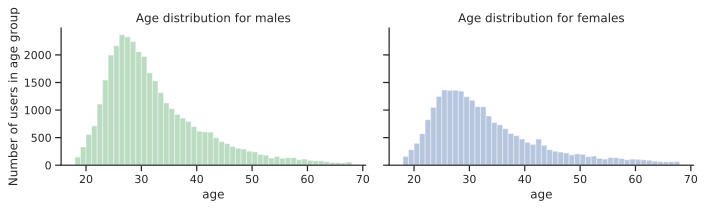

In [21]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3),sharey=True,sharex=True)
sns.distplot(male["age"], ax=ax1,
             bins=range(d["age"].min(),d["age"].max()),
             kde=False,
             color="g")
ax1.set_title("Age distribution for males")
sns.distplot(female["age"], ax=ax2,
             bins=range(d["age"].min(),d["age"].max()),
             kde=False,
             color="b")
ax2.set_title("Age distribution for females")
ax1.set_ylabel("Number of users in age group")
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

Note that both distributions are right-skewed. Then, as is often (but not always!) the case, the mean is larger than the median.

In [22]:
print("Mean and median age for males:   {:.2f}, {:.2f}".format(male["age"].mean(),male["age"].median()))
print("Mean and median age for females: {:.2f}, {:.2f}".format(female["age"].mean(),female["age"].median()))

Mean and median age for males:   32.02, 30.00
Mean and median age for females: 32.82, 30.00


Females seem to be on average slightly older than males. Let's compare the age distributions in a single plot

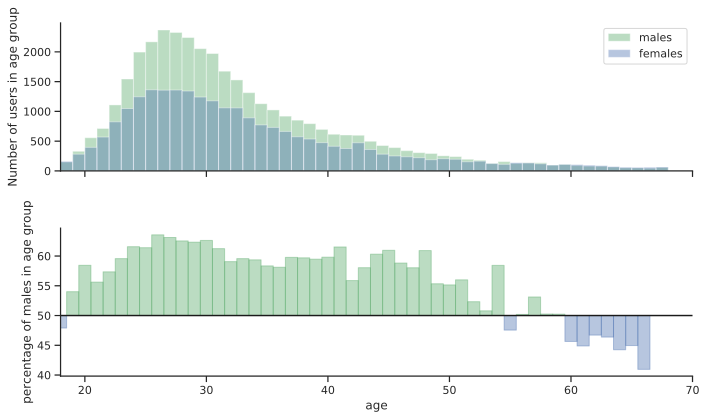

In [23]:
#########################################################################################################

fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
# Plot the age distributions of males and females on the same axis
sns.distplot(male["age"], ax=ax1,
             bins=range(d["age"].min(),d["age"].max()),
             kde=False,
             color="g",
             label="males")
sns.distplot(female["age"], ax=ax1,
             bins=range(d["age"].min(),d["age"].max()),
             kde=False,
             color="b",
             label="females")
ax1.set_ylabel("Number of users in age group")
ax1.set_xlabel("")
ax1.legend()

# Compute the fraction of males for every age value
fraction_of_males=(male["age"].value_counts()/d["age"].value_counts())
# Ignore values computed from age groups in which we have less than 100 total users (else estimates are too unstable)
fraction_of_males[d["age"].value_counts()<100]=None
barlist=ax2.bar(x=fraction_of_males.index,
        height=fraction_of_males*100-50,
        bottom=50, width=1, color="gray")
for bar,frac in zip(barlist,fraction_of_males):
    bar.set_color("g" if frac>.5 else "b")
    bar.set_alpha(0.4)
ax2.set_xlim([18,70])
ax2.set_xlabel("age")
ax2.set_ylabel("percentage of males in age group")
ax2.axhline(y=50,color="k")

for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

Over-60 users are not many, but in this group there are significantly more females than males. This may be explained by the fact that, in this age group, there are more females than males in the general population.

In [25]:
##########################################################################################################

# Age distributions of age in jointplots
sns.jointplot(male['age'], female['age'], kind="hex", stat_func=kendalltau, color="#4CB391")

#### Study height distribution and compare with official data from the US Centers of Disease Control and Prevention ([CDC](https://www.cdc.gov/))
We first plot the height distribution for males and females in the whole dataset

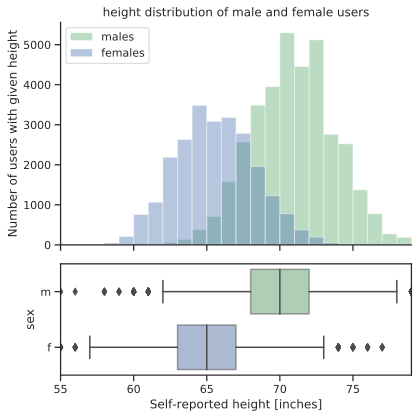

In [26]:
fig,(ax,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(6,6),gridspec_kw={'height_ratios':[2,1]})
# Plot histograms of height
bins=range(55,80)
sns.distplot(male["height"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="g",
             label="males")
sns.distplot(female["height"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="b",
             label="females")
ax.legend(loc="upper left")
ax.set_xlabel("")
ax.set_ylabel("Number of users with given height")
ax.set_title("height distribution of male and female users");

# Make aligned boxplots
sns.boxplot(data=d,y="sex",x="height",orient="h",ax=ax2,palette={"m":"g","f":"b"})
plt.setp(ax2.artists, alpha=.5)
ax2.set_xlim([min(bins),max(bins)])
ax2.set_xlabel("Self-reported height [inches]")

sns.despine(ax=ax)
fig.tight_layout()

Males are (as suspected) taller than females, and the two distributions make sense.

How does this compare with general population data? Are OkCupid users maybe cheating and overreporting their height?

The CDC publishes growth charts, which contain height data for the general US population. The dataset reports statistics (3rd, 5th, 10th, 25th, 50th, 75th, 90th, 95th, 97th percentiles) for stature for different ages from 2 to 20 years. This (and more) data is plotted by the CDC in these beautiful charts.

#### Generate a new collection to store CDC data #################
The idea is to cross databases attributes to compare CDC versus OKCupid


In [27]:
col_cdc = db.cdcdb

#Import data into the database
col_cdc.drop()

In [28]:
records = json.loads(pd.read_csv("https://www.cdc.gov/growthcharts/data/zscore/statage.csv").to_json(orient='records'))
col_cdc.delete_many({})
col_cdc.insert_many(records)

In [29]:
#Check if you can access the data from the MongoDB.
cursor = col_cdc.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e8b60258dc350fdc7c186ea'), 'Sex': 1, 'Agemos': 24.0, 'L': 0.941523967, 'M': 86.45220101, 'S': 0.040321528, 'P3': 79.91084447, 'P5': 80.72977321, 'P10': 81.99171445, 'P25': 84.10289217, 'P50': 86.45220101, 'P75': 88.80524943, 'P90': 90.92619137, 'P95': 92.19687928, 'P97': 93.02265441}
{'_id': ObjectId('5e8b60258dc350fdc7c186eb'), 'Sex': 1, 'Agemos': 24.5, 'L': 1.00720807, 'M': 86.86160934, 'S': 0.040395626, 'P3': 80.26037074, 'P5': 81.08868489, 'P10': 82.36400989, 'P25': 84.49470553, 'P50': 86.86160934, 'P75': 89.22804829, 'P90': 91.35753004, 'P95': 92.63176749, 'P97': 93.45923029}
{'_id': ObjectId('5e8b60258dc350fdc7c186ec'), 'Sex': 1, 'Agemos': 25.5, 'L': 0.837251351, 'M': 87.65247282, 'S': 0.040577525, 'P3': 81.0052937, 'P5': 81.83445202, 'P10': 83.11387064, 'P25': 85.25887745, 'P50': 87.65247282, 'P75': 90.05675457, 'P90': 92.22966054, 'P95': 93.53406648, 'P97': 94.38278047}
{'_id': ObjectId('5e8b60258dc350fdc7c186ed'), 'Sex': 1, 'Agemos': 26.5, 'L': 0.681492975, 

In [30]:
# Transform data attribute "Sex" to accomodate to OKCupid format
col_cdc.update_many({"Sex":1},{'$set':{"Sex":"m"}})
col_cdc.update_many({"Sex":2},{'$set':{"Sex":"f"}})

cdc = pd.DataFrame(list(col_cdc.find()))
cdc.head(5)

,_id,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P90,P95,P97
0,5e8b60258dc350fdc7c186ea,m,24.0,0.941524,86.452201,0.040322,79.910844,80.729773,81.991714,84.102892,86.452201,88.805249,90.926191,92.196879,93.022654
1,5e8b60258dc350fdc7c186eb,m,24.5,1.007208,86.861609,0.040396,80.260371,81.088685,82.364010,84.494706,86.861609,89.228048,91.357530,92.631767,93.459230
2,5e8b60258dc350fdc7c186ec,m,25.5,0.837251,87.652473,0.040578,81.005294,81.834452,83.113871,85.258877,87.652473,90.056755,92.229661,93.534066,94.382780
3,5e8b60258dc350fdc7c186ed,m,26.5,0.681493,88.423264,0.040723,81.734157,82.564061,83.847162,86.005173,88.423264,90.862604,93.076082,94.408849,95.277617
4,5e8b60258dc350fdc7c186ee,m,27.5,0.538780,89.175492,0.040833,82.448456,83.278986,84.565344,86.735069,89.175492,91.647114,93.898271,95.257541,96.145118


In [31]:
cdc.tail(5)

,_id,Sex,Agemos,L,M,S,P3,P5,P10,P25,P50,P75,P90,P95,P97
431,5e8b60258dc350fdc7c18899,f,236.5,1.101363,163.317535,0.039642,151.093368,152.632203,154.998646,158.944742,163.317535,167.678491,171.593672,173.932413,175.449558
432,5e8b60258dc350fdc7c1889a,f,237.5,1.103342,163.323723,0.039640,151.098687,152.637736,155.004448,158.950835,163.323723,167.684544,171.599413,173.937884,175.454821
433,5e8b60258dc350fdc7c1889b,f,238.5,1.105265,163.329692,0.039639,151.103815,152.643072,155.010045,158.956712,163.329692,167.690380,171.604944,173.943152,175.459885
434,5e8b60258dc350fdc7c1889c,f,239.5,1.107133,163.335449,0.039637,151.108761,152.648219,155.015445,158.962383,163.335449,167.696006,171.610274,173.948224,175.464760
435,5e8b60258dc350fdc7c1889d,f,240.0,1.108046,163.338251,0.039636,151.111167,152.650723,155.018073,158.965143,163.338251,167.698744,171.612865,173.950690,175.467129


In [32]:
# Adjust the data to fit our format
cdc["Age"]=cdc["Agemos"]/12 # convert age in months to age in fractional years

In [33]:
percentiles=[3,5,10,25,50,75,90,95,97]
percentile_columns=["P"+str(p) for p in percentiles] # names of percentile columns
cdc[percentile_columns]=cdc[percentile_columns]*0.393701 # convert percentile columns from centimeters to inches (ugh)
cdc20=cdc[cdc["Age"]==20].set_index("Sex") # Select the two rows corresponding to 20-year-olds (males and females)

In [35]:
print("Height Percentiles for 20-year-old US population [inches]")
display(PrettyPandas(cdc20[percentile_columns],precision=4))

Height Percentiles for 20-year-old US population [inches]


/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/prettypandas/summarizer.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[col_ix] = df.loc[col_ix].fillna('')
/home/master/Aplicaciones/anaconda-navigator/lib/python3.7/site-packages/prettypandas/summarizer.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

,P3,P5,P10,P25,P50,P75,P90,P95,P97
Sex,,,,,,,,,
m,64.304496,64.975961,66.007627,67.725520,69.625720,71.517283,73.212615,74.224061,74.879691
f,59.492618,60.098742,61.030770,62.584736,64.306433,66.023163,67.564157,68.484561,69.081584


#### Let's compare the stats for reported heights of our 20-year-olds to the CDC stats for 20-year-olds.

Note that OKCupid height data are integers, which also causes all percentiles to be integer values. To fix this, we jitter the data by ±0.5±0.5 inches by adding random uniformly distributed noise in the range [−0.5,+0.5][−0.5,+0.5] (which won't affect the mean, but will smooth the percentiles). This makes sense if we assume that users reported their height rounded to the nearest inch.

In [36]:
mheights=male.loc[male["age"]==20,"height"] # heights of 20-year-old males
fheights=female.loc[female["age"]==20,"height"] # heights of 20-year-old females

In [37]:
# To smooth the computation of percentiles, jitter height data by adding
# uniformly distributed noise in the range [-0.5,+0.5]
mheightsj=mheights+np.random.uniform(low=-0.5,high=+0.5,size=(len(mheights),))
fheightsj=fheights+np.random.uniform(low=-0.5,high=+0.5,size=(len(fheights),))

In [38]:
# For each of the available percentiles in CDC data, compute the corresponding percentile from our 20-year-old users
stats=[]
for percentile,percentile_column in zip(percentiles,percentile_columns):
    stats.append({"sex":"m",
                  "percentile":percentile,
                  "CDC":cdc20.loc["m",percentile_column],
                  "users":mheightsj.quantile(percentile/100)})
    stats.append({"sex":"f",
                  "percentile":percentile,
                  "CDC":cdc20.loc["f",percentile_column],
                  "users":fheightsj.quantile(percentile/100)})
stats=pd.DataFrame(stats).set_index(["sex","percentile"]).sort_index()

# For each percentile, compute the gap between users and CDC
stats["gap"]=stats["users"]-stats["CDC"]

print("Height percentiles (in inches) for 20-year-old males")
display(PrettyPandas(stats.loc["m"],precision=4))

Height percentiles (in inches) for 20-year-old males


,CDC,users,gap
percentile,,,
3,64.304496,64.910864,0.606367
5,64.975961,65.533886,0.557925
10,66.007627,66.009191,0.001563
25,67.725520,67.988420,0.262900
50,69.625720,70.204261,0.578542
75,71.517283,72.218468,0.701186
90,73.212615,74.162568,0.949954
95,74.224061,75.348075,1.124014
97,74.879691,75.911404,1.031713


In [39]:
print("Height percentiles (in inches) for 20-year-old females")
display(PrettyPandas(stats.loc["f"],precision=4))

Height percentiles (in inches) for 20-year-old females


,CDC,users,gap
percentile,,,
3,59.492618,59.689292,0.196674
5,60.098742,59.977382,-0.121360
10,61.030770,61.073459,0.042689
25,62.584736,62.817764,0.233028
50,64.306433,64.904928,0.598495
75,66.023163,66.685631,0.662468
90,67.564157,68.412278,0.848121
95,68.484561,69.467675,0.983114
97,69.081584,70.007337,0.925753


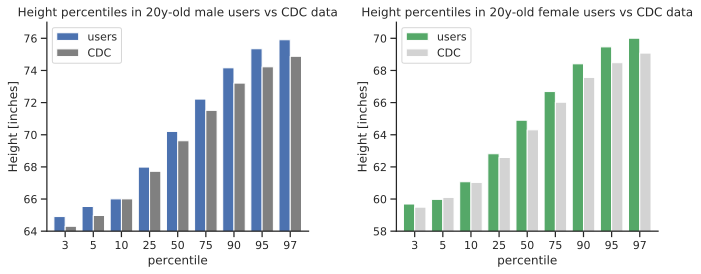

In [40]:
#PLOT the differences

fig,(ax1,ax2)=plt.subplots(ncols=2,sharex=True,figsize=(10,4))
#stats.loc["m"][["users","CDC"]].plot.bar(ax=ax1,color=[[0.5,0.5,1],"k"],alpha=1,width=0.8,rot=0)
stats.loc["m"][["users","CDC"]].plot.bar(ax=ax1,color=["b","grey"],alpha=1,width=0.8,rot=0)
stats.loc["f"][["users","CDC"]].plot.bar(ax=ax2,color=["g","lightgrey"],alpha=1,width=0.8,rot=0)
ax1.set_ylim([64,77])
ax2.set_ylim([58,71])
ax1.set_ylabel("Height [inches]")
ax2.set_ylabel("Height [inches]")
ax1.set_title("Height percentiles in 20y-old male users vs CDC data")
ax2.set_title("Height percentiles in 20y-old female users vs CDC data")
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

In [41]:
#################################################################
d["height"].isnull().sum()

3

#### Study how height changes with age

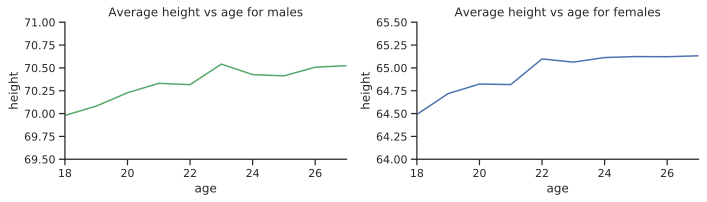

In [42]:
# Investigate heights vs sex vs age
g=d.groupby(["sex","age"])["height"].mean()
fig,(ax1,ax2)=plt.subplots(ncols=2,sharex=True,figsize=(10,3))
ax1.plot(g["m"],color="g")
ax1.set_xlim(18,27)
ax1.set_ylim(69.5,71)
ax1.set(title="Average height vs age for males",
        ylabel="height",
        xlabel="age")
ax2.plot(g["f"],color="b")
ax2.set_xlim(18,27)
ax2.set_ylim(64,65.5)
ax2.set(title="Average height vs age for females",
        ylabel="height",
        xlabel="age");
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

In [43]:
### We can also overlay CDC growth charts to the above plots, with minimal data wrangling.

cdc_m=cdc[cdc["Sex"]=="m"].groupby(np.floor(cdc["Age"]))[percentile_columns].mean()
cdc_f=cdc[cdc["Sex"]=="f"].groupby(np.floor(cdc["Age"]))[percentile_columns].mean()

# Result for males
display(PrettyPandas(cdc_m,precision=4))


,P3,P5,P10,P25,P50,P75,P90,P95,P97
Age,,,,,,,,,
2.0,32.987669,33.314112,33.820946,34.679306,35.650161,36.639509,37.546155,38.096239,38.456533
3.0,35.943701,36.298481,36.849784,37.784722,38.844035,39.925440,40.918060,41.521029,41.916247
4.0,38.281754,38.695797,39.332537,40.394379,41.571167,42.744938,43.798898,44.428570,44.837077
5.0,40.537743,40.995777,41.698655,42.866802,44.155744,45.435657,46.580211,47.261934,47.703396
6.0,42.829720,43.313445,44.058640,45.304775,46.690706,48.078083,49.327995,50.076570,50.562939
7.0,45.091998,45.594013,46.371390,47.682151,49.155745,50.647409,52.005337,52.824947,53.360007
8.0,47.168708,47.696647,48.516284,49.904081,51.472873,53.070070,54.532004,55.418019,55.997892
9.0,48.975071,49.540938,50.419159,51.905317,53.584029,55.291749,56.853618,57.799627,58.418531
10.0,50.608163,51.214006,52.153770,53.742691,55.535397,57.356818,59.020688,60.027558,60.685907


In [44]:
# Result for females
display(PrettyPandas(cdc_f,precision=4))

,P3,P5,P10,P25,P50,P75,P90,P95,P97
Age,,,,,,,,,
2.0,32.467830,32.809055,33.335526,34.218054,35.202714,36.191656,37.085364,37.621844,37.970903
3.0,35.334244,35.701838,36.272403,37.238137,38.329355,39.439883,40.456020,41.071714,41.474618
4.0,37.765826,38.160497,38.775569,39.823527,41.018131,42.245346,43.378440,44.069757,44.524096
5.0,40.273320,40.694632,41.353289,42.481343,43.776292,45.116710,46.363506,47.128554,47.633157
6.0,42.757829,43.208057,43.912767,45.122096,46.514099,47.959223,49.307297,50.136349,50.683942
7.0,45.045094,45.527147,46.281123,47.573426,49.058459,50.597332,52.030244,52.910208,53.490900
8.0,47.021987,47.538723,48.345556,49.724506,51.302942,52.931648,54.441851,55.366249,55.975002
9.0,48.717467,49.276115,50.146737,51.630050,53.320743,55.057248,56.660151,57.637864,58.280312
10.0,50.401183,51.021161,51.983626,53.613071,55.454723,57.329364,59.044917,60.084480,60.764781


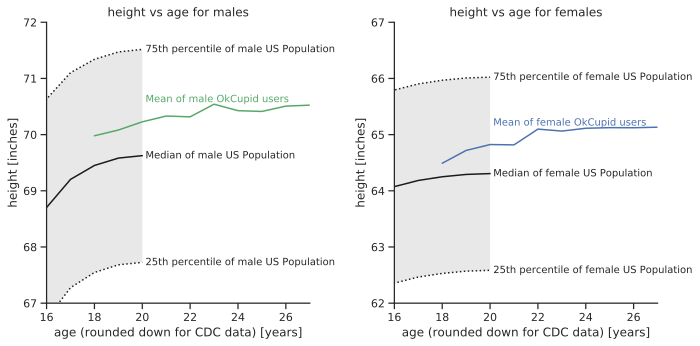

In [45]:
############################################################# Compare CDC and OKCupid Percentiles #######################################################
# Compute average height per sex and age
g=d.groupby(["sex","age"])["height"].mean()

fig,(ax1,ax2)=plt.subplots(ncols=2,sharex=True,figsize=(10,5))
ax1.plot(g["m"],color="g",label="Mean of male OkCupid users")
ax1.plot(cdc_m["P75"],color="k",linestyle='dotted',label="75th percentile of male US Population")
ax1.plot(cdc_m["P50"],color="k",label="Median of male US Population")
ax1.plot(cdc_m["P25"],color="k",linestyle='dotted',label="25th percentile of male US Population")
ax1.fill_between(cdc_m.index,cdc_m["P25"],cdc_m["P75"],color="k",alpha=0.1,linewidth=0)



#ax1.legend(loc="lower right")
# Use direct labeling instead of a legend
x=cdc_m["P50"].index[-1]
ax1.text(x, g["m"].loc[:26].max(), " Mean of male OkCupid users", color="g",
         verticalalignment="bottom",fontsize="small")
ax1.text(x, cdc_m["P75"].iloc[-1]," 75th percentile of male US Population",
         verticalalignment="center",fontsize="small")
ax1.text(x, cdc_m["P50"].iloc[-1]," Median of male US Population",
         verticalalignment="center",fontsize="small")
ax1.text(x, cdc_m["P25"].iloc[-1]," 25th percentile of male US Population",
         verticalalignment="center",fontsize="small")

ax1.set_xlim(16,27)
ax1.set_ylim(67,72)
ax1.set(title="height vs age for males",
        ylabel="height [inches]",
        xlabel="age (rounded down for CDC data) [years]");
ax2.plot(g["f"],color="b",label="Mean of female OkCupid users")
ax2.plot(cdc_f["P75"],color="k",linestyle='dotted',label="75th percentile of female US Population")
ax2.plot(cdc_f["P50"],color="k",label="Median of female US Population")
ax2.plot(cdc_f["P25"],color="k",linestyle='dotted',label="25th percentile of female US Population")
ax2.fill_between(cdc_f.index,cdc_f["P25"],cdc_f["P75"],color="k",alpha=0.1,linewidth=0)

#ax2.legend(loc="lower right")
# Use direct labeling instead of a legend
x=cdc_f["P50"].index[-1]
ax2.text(x, g["f"].loc[:26].max(), " Mean of female OkCupid users", color="b",
         verticalalignment="bottom",fontsize="small")
ax2.text(x, cdc_f["P75"].iloc[-1]," 75th percentile of female US Population",
         verticalalignment="center",fontsize="small")
ax2.text(x, cdc_f["P50"].iloc[-1]," Median of female US Population",
         verticalalignment="center",fontsize="small")
ax2.text(x, cdc_f["P25"].iloc[-1]," 25th percentile of female US Population",
         verticalalignment="center",fontsize="small")

ax2.set_xlim(16,27)
ax2.set_ylim(62,67)
ax2.set(title="height vs age for females",
        ylabel="height [inches]",
        xlabel="age (rounded down for CDC data) [years]");
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

#### How do users self-report their body type?
An interesting categorical attribute body_type contains the self-reported body type of the user, chosen from a limited set of options.

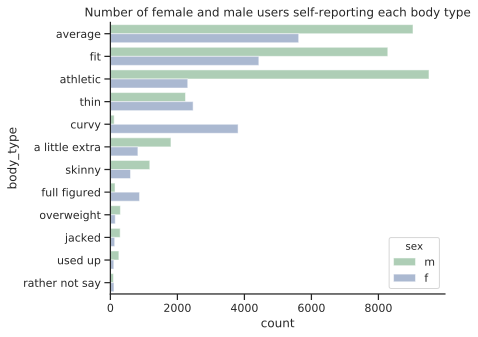

In [46]:
fig,ax=plt.subplots(figsize=(6,5))
sns.countplot(y="body_type",hue="sex",
              order=d["body_type"].value_counts().sort_values(ascending=False).index,
              data=d,palette={"m":"g","f":"b"},alpha=0.5,ax=ax);
ax.set_title("Number of female and male users self-reporting each body type")
sns.despine(ax=ax)

In the plot above, males and females are two sub-groups of the population, whereas body_type is a categorical attribute. It is interesting to compare how users in each of the two sub-groups (i.e. males and females) are likely to use each of the available categorical values; this is normally done through contingency tables.

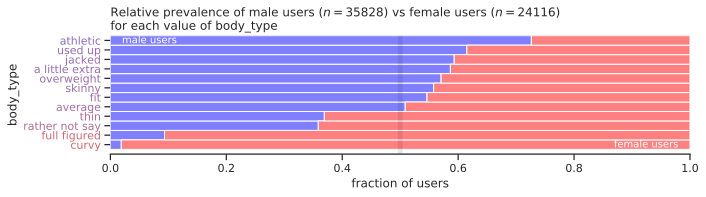

In [47]:
# Define visualization function
def compare_prevalence(series,g1,g2,g1name,g2name,g1color,g2color,ax):
    
    # for each categorical value represented in series, number of users in group g1 which have this value
    g1n=series.loc[g1].value_counts()
    # for each categorical value represented in series, number of users in group g2 which have this value
    g2n=series.loc[g2].value_counts()
    
    # join the two series in a single dataframe, filling 0 where indices don't match
    # (e.g. if a value represented in g1 did never appear in g2)
    df=pd.concat({"g1n":g1n,"g2n":g2n},axis=1).fillna(0)
    # df has one row for every distinct value of series in the union of g1 and g2
    
    # normalize the data
    df["g1f"]=df["g1n"]/(df["g1n"].sum()) # fraction of g1 users with each categorical value
    df["g2f"]=df["g2n"]/(df["g2n"].sum()) # fraction of g2 users with each categorical value
    
    assert(math.isclose(df["g1f"].sum(),1)) 
    assert(math.isclose(df["g2f"].sum(),1))
    
    # for each row of df, we now compute how frequent the value was in g1 compared to the frequency it had in g2.
    df["frac12"]=df["g1f"]/(df["g1f"]+df["g2f"])
    # we expect df["frac12"] to be 0.5 for values that were equally frequent in g1 and g2 (note that this does not depend on the size of g1 and g2)
    # we expect df["frac12"] to be 0 for values that were only seen in g2 and never seen in g1
    # we expect df["frac12"] to be 1 for values that were only seen in g1 and never seen in g2
    
    df=df[(df["g1n"]+df["g2n"])>=50] # exclude values which are too rare
    df=df.sort_values("frac12")
    
    # Draw the left bars
    ax.barh(y=range(len(df)),
                width=df["frac12"],
                left=0,
                height=1,
                align="center",
                color=g1color,alpha=1)
    # Draw the right bars
    ax.barh(y=range(len(df)),
                width=df["frac12"]-1,
                left=1,
                height=1,
                align="center",
                color=g2color,alpha=1)
    
    # Draw a faint vertical line for x=0.5
    ax.axvline(x=0.5,color="k",alpha=0.1,linewidth=5)
    ax.set(xlim=[0,1],
           ylim=[-1,len(df)-0.5],
           yticks=range(len(df)),
           yticklabels=df.index,
           xlabel="fraction of users",
           ylabel=series.name)
    
    ax.set_title("Relative prevalence of {} ($n={}$) vs {} ($n={}$)\nfor each value of {}".format(
                g1name,g1.sum(),g2name,g2.sum(),series.name),
                loc="left",fontdict={"fontsize":"medium"})
    ax.text(0.02,len(df)-1,g1name,verticalalignment="center",horizontalalignment="left",size="smaller",color="w")
    ax.text(0.98,0,g2name,verticalalignment="center",horizontalalignment="right",size="smaller",color="w")

    def color_for_frac(f):
        # Blend g1color and g2color according to f (convex linear combination):
        # 0 returns g1color, 1 returns g2color)
        ret=np.array(g1color)*f+np.array(g2color)*(1-f)
        if(np.linalg.norm(ret)>1):          # If the resulting rgb color is too bright for text,
            ret=(ret/np.linalg.norm(ret))*1 # rescale its brightness to dark (but keep hue)
        return ret
        
    for i,tl in enumerate(plt.gca().get_yticklabels()):
        tl.set_color(color_for_frac(df["frac12"].iloc[i]))
        
    sns.despine(ax=ax,left=True)

# Apply visualization function 
fig,ax = plt.subplots(figsize=(10,3))
compare_prevalence(
    series=d["body_type"],                          # Which categorical attribute?
    g1=d["sex"]=="m",      g2=d["sex"]=="f",        # Definition of the two groups
    g1name="male users",   g2name="female users",   # Names of the two groups
    g1color=[0.5,0.5,1.0], g2color=[1.0,0.5,0.5],   # Colors for the two groups
    ax=ax)
fig.tight_layout()


### Analyzing essays
##### The data contains essays written by the users on the following topics:
- essay0: My self summary
- essay1: What I’m doing with my life
- essay2: I’m really good at
- essay3: The first thing people usually notice about me
- essay4: Favorite books, movies, show, music, and food
- essay5: The six things I could never do without
- essay6: I spend a lot of time thinking about
- essay7: On a typical Friday night I am
- essay8: The most private thing I am willing to admit
- essay9: You should message me if...

In [48]:
# In the following, we concatenate all essays to a single string and ignore the different themes.
d["essays"]=""
for f in ["essay"+str(i) for i in range(10)]:
    d.loc[d[f].isnull(),f]=""
    d["essays"]=d["essays"]+" "+d[f]

In [49]:
# Let's index and count all unique words in all essays.
from collections import Counter
wordcounts=Counter()
for e in d["essays"].str.split():
    wordcounts.update([w.strip(string.whitespace+string.punctuation) for w in e])

In [50]:
for w,c in wordcounts.most_common(100):
    print(c,w)

1050302 
823608 i
714584 and
679436 a
626851 the
595608 to
360865 my
356508 of
296365 in
268116 br
196373 i'm
186633 you
175822 with
171168 for
166527 that
149093 is
141352 have
134013 like
132263 it
129212 but
129154 on
127508 or
123236 me
118698 am
116091 love
115337 at
99079 be
98902 not
90958 are
90318 out
87647 good
86923 as
84950 class="ilink
82377 if
74561 about
73716 people
69199 friends
68811 music
68369 can
68302 all
67427 just
66826 so
66029 life
65444 time
61892 do
61468 things
60819 what
60015 an
58892 this
57509 new
55204 up
54636 don't
53830 really
53444 food
53272 also
52922 from
50968 some
49272 who
48840 more
48132 get
46711 how
45745 href
44850 when
44345 know
44218 want
42961 by
42739 being
42660 work
41730 one
41434 movies
39353 think
39091 it's
38851 i've
37163 enjoy
36682 much
36486 anything
36457 going
35598 go
34765 was
33821 would
33679 will
33593 been
33444 books
33418 make
32445 your
31981 most
31563 fun
31116 very
30870 lot
30641 too
29730 working
29343 loo

In [51]:
# Among tha 10k most common words, we filter those with at least 4 characters. We build a dataframe that contains a binary column 
# for each of these and a row for each user. The value will be True where if the user's essay contains the word, False otherwise.

#import tqdm # a cool progress bar

# Let's consider the most common 10k words
#words=[w for w,c in wordcounts.most_common(10000) if len(w)>=4 and w.isalpha()]

words=[w for w,c in wordcounts.most_common(100) if len(w)>=4 and w.isalpha()]


In [53]:
d_contains=pd.DataFrame(index=d.index)
# This operation takes a lot of time
for w in tqdm.tqdm(words):
    d_contains[w]=d["essays"].str.contains("\\b"+w+"\\b")

100%|██████████| 50/50 [03:45<00:00,  4.52s/it]


In [54]:
# These frequent words were part of the html and we should ignore them
d_contains=d_contains.drop("href",axis=1)
#d_contains=d_contains.drop("ilink",axis=1)
d_contains.to_pickle("d_contains.pickle") # Save a cache

print("The dataset contains {} rows (users) and {} columns (words)".format(
        len(d_contains.index),len(d_contains.columns)))

The dataset contains 59944 rows (users) and 49 columns (words)


#### Let's visualize the resulting dataframe.

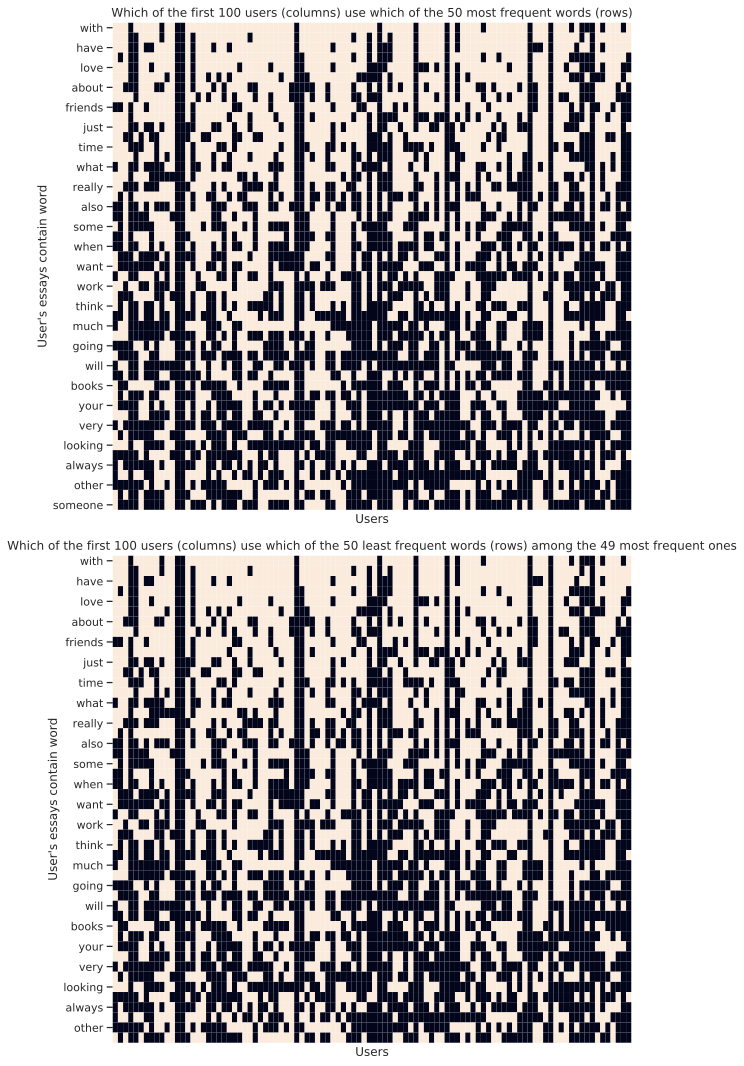

In [55]:

#We show the transpose of the dataframe, i.e. one row per word and one column per user. 
#We only display 100 users (i.e. less than one hundreth of all users in the dataset), and 100 words 
#(i.e. about 1/80th of all the frequent words we found)

fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,15))
sns.heatmap(d_contains.iloc[0:100,0:49].transpose(),
            ax=ax1,cbar=None)
sns.heatmap(d_contains.iloc[0:100,-49:-1].transpose(),
            ax=ax2,cbar=None)
ax1.set_title("Which of the first 100 users (columns) use which of the 50 most frequent words (rows)")
ax2.set_title("Which of the first 100 users (columns) use which of the 50 least frequent words (rows) among the "+str(d_contains.shape[1])+" most frequent ones")
for ax in (ax1,ax2):
    ax.set_xticks([])
    ax.set_xlabel("Users")
    ax.set_ylabel("User's essays contain word")
fig.tight_layout()

In [57]:
print(d["essays"].str.contains("\\bbinding of isaac\\b").sum())
print(d["essays"].str.contains("\\bisaac asimov\\b").sum())
print(d["essays"].str.contains("\\basimov\\b").sum())
d["essays"].str.extract("(\\bisaac [a-z]*\\b)").dropna().value_counts()

0
159
394


####  Mongo Queries Essays Patters 

In [58]:
#Check if you can access the data from the MongoDB. For example, we focus on essay5, but other essays can be examined
cursor = collection.find().limit(50)
#for doc in cursor:
#    print(doc["essay5"])

In [59]:
### Stablishing patters to search and find common areas of interest between males and fmales
pattern = "likes dogs"
pattern3 = "sports" 
pattern2 = "family" 
pat = re.compile(pattern3, re.I)
   
pipeline1 = [{"$match": {"education":"graduated from college/university" , 'essay5': {'$regex': pat}}}]

pipeline2 = [{"$match": {"speaks":"english (fluently)" , 'essay5': {'$regex': pat}}}]

pipeline3 = [{"$match": {"speaks":"spanish" , 'essay5': {'$regex': pat}}}]



In [60]:
aggResult = collection.aggregate(pipeline1)
dfe = pd.DataFrame(list(aggResult))
dfe.head()

,_id,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,5e8b5fbd8dc350fdc7c09cc8,24,None,strictly anything,socially,None,graduated from college/university,None,"oh goodness. at the moment i have 4 jobs, so i...",None,...,"belvedere tiburon, california",doesn&rsquo;t have kids,straight,likes dogs and likes cats,christianity but not too serious about it,f,gemini but it doesn&rsquo;t matter,when drinking,english,single
1,5e8b5fbd8dc350fdc7c09cd6,30,fit,mostly anything,socially,never,graduated from college/university,i tend to think the same way a comedian does a...,i'm a supply and demand manager for a sustaina...,"making predictions, planning anything (i'm pre...",...,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and somewhat serious about it,m,sagittarius but it doesn&rsquo;t matter,no,"english, spanish (poorly)",single
2,5e8b5fbd8dc350fdc7c09e6c,29,athletic,anything,socially,never,graduated from college/university,None,None,"being a handy man, from working on cars to fix...",...,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,None,None,m,libra,no,english,single
3,5e8b5fbd8dc350fdc7c09e99,33,athletic,mostly anything,socially,sometimes,graduated from college/university,city rat meets twinkie monkey,i'm sorta between countries right now. used to...,bhangra. i wish i could do the side-to-side ne...,...,"oakland, california",None,straight,likes dogs and likes cats,christianity but not too serious about it,m,taurus but it doesn&rsquo;t matter,trying to quit,"english (fluently), korean (poorly), spanish (...",single
4,5e8b5fbd8dc350fdc7c09ecb,28,athletic,None,socially,never,graduated from college/university,i think of myself as an upbeat individual with...,i have a pretty sweet gig doing rental housing...,"holding my breath, occasionally talking too mu...",...,"san francisco, california",None,straight,likes dogs and has cats,agnosticism but not too serious about it,m,sagittarius and it&rsquo;s fun to think about,no,"english (fluently), spanish (fluently)",single


In [61]:
# Explore other specific patterns
dfe["essay5"].str.extract("(\\bfootball [a-z]*\\b)").dropna()

,0
33,football sundays
161,football and
252,football and
359,football and
